In [2]:
import sys
sys.path.append("/tf/massimal/python/massimal/tools")

In [163]:
# Imports
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import skimage
# "Local import" from massimal repository (https://github.com/mh-skjelvareid/massimal)
import annotation, image_render, hyspec_io, misc, hyspec_stats
import importlib
#importlib.reload(hyspec_stats)

import sklearn.preprocessing
import sklearn.decomposition
import math

In [4]:
# Parameters
TILE_SHAPE = (128,128)
TEST_FRAC = 0.3
BATCH_SIZE = 8

In [5]:
# Function for extracting tiles
def labeled_image_to_tensor_tiles(image,labels,tile_shape,
                                  tile_strides=None,padding='SAME',
                                  include_unlabeled = False):
    """ Split image and label mask into smaller tiles
    
    # Usage:
    (image_tiles,label_tiles) = ...
    
    # Input arguments:
    image:        3D numpy array with dimensions (rows, columns, channels)
    labels:       2D numpy array with dimensions (rows,columns)
    tile_shape:   Tuple of integers, (tile_rows, tile_cols)
    
    # Keyword arguments
    tile_strides: Tuple of integers, (row_stride, col_stride)
                  If None, set equal to tile_shape (no overlap between tiles)
    padding:      'VALID' or 'SAME' (see tensorflow.image.extract_patches)
                  Default: 'SAME'
    include_unannotated
    """
    
    if tile_strides is None: tile_strides = tile_shape
    
    image_tensor = tf.reshape(tf.convert_to_tensor(image),(1,)+image.shape)
    label_tensor = tf.reshape(tf.convert_to_tensor(labels),(1,)+labels.shape + (1,))
    
    sizes = [1,*tile_shape,1]
    strides = [1,*tile_strides,1]
    rates = [1,1,1,1]
    
    image_tiles = tf.image.extract_patches(image_tensor, sizes, strides, rates, padding=padding)
    image_tiles = tf.reshape(image_tiles,[-1,*tile_shape,image.shape[-1]])
    label_tiles = tf.image.extract_patches(label_tensor, sizes, strides, rates, padding=padding)
    label_tiles = tf.reshape(label_tiles,[-1,*tile_shape])
    
    if not include_unlabeled:
        labeled_tiles_mask = np.array([not(tf.math.reduce_all(tile==0)) for tile in label_tiles])
        image_tiles = tf.boolean_mask(image_tiles,labeled_tiles_mask)
        label_tiles = tf.boolean_mask(label_tiles,labeled_tiles_mask)
        
    return image_tiles, label_tiles


In [6]:
# Paths
# json_gray = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/label_classes.json'
# annotation_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/Selected_Annotation_Images'
# hyspec_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4_Rad_Georef_SGC'

json_gray = '/tf/massimal/data/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/label_classes.json'
annotation_dir = '/tf/massimal/data/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/Selected_Annotation_Images'
hyspec_dir = '/tf/massimal/data/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4_Rad_Georef_SGC'

In [7]:
# Find paths to annotated images
ann_file_paths_str = misc.file_pattern_search(annotation_dir,'*.png')
ann_file_paths = [pathlib.Path(fn) for fn in ann_file_paths_str]
for p in ann_file_paths:
    print(p.name)

OlbergholmenS_Pika_L_12-Radiance From Raw Data-Georectify Airborne Datacube.png
OlbergholmenS_Pika_L_15-Radiance From Raw Data-Georectify Airborne Datacube.png
OlbergholmenS_Pika_L_16-Radiance From Raw Data-Georectify Airborne Datacube.png
OlbergholmenS_Pika_L_17-Radiance From Raw Data-Georectify Airborne Datacube.png


In [8]:
# Read annotation metadata file, show classes
class_dict = annotation.read_hasty_metadata(json_gray)
for class_name,class_ind in class_dict.items():
    print(f'{class_name}: {class_ind}')

Sand: 1
Gravel: 2
Mud: 3
Terrestrial: 4
Zostera marina - dominant: 5
Zostera marina - normal: 6
Zostera marina - sparse: 7
Zostera marina with turf algae: 8
Turf algae - dominant: 9
Turf algae - normal: 10
Turf algae - sparse: 11
Rockweed: 12
Rockweed with turf algae: 13
Fucus serratus: 14
Aegagropila (algae ball): 15
Mixed algae classes on soft substrate: 16
Saccharina latissima: 17


In [9]:
# Define classes to keep / merge
classes_to_merge = [['Sand'],
                    ['Zostera marina - dominant', 'Zostera marina - normal', 'Zostera marina - sparse'],
                    ['Zostera marina with turf algae']]
merged_class_names = ['Sand', 'Zostera marina', 'Zostera marina with turf algae']

In [10]:
# Loop through images, spilt into tiles
hyspec_tiles = []
annotation_tiles = []
for annotation_file in ann_file_paths:
    # Load hyperspectral image
    hyspec_file = pathlib.Path(hyspec_dir) / (annotation_file.stem + '.bip.hdr')
    hyspec_image, wl, rgb_ind, metadata = hyspec_io.load_envi_image(hyspec_file)
    # Load annotation image
    class_mask = skimage.io.imread(annotation_file)
    class_mask[np.all(hyspec_image==0,axis=2)] = 0        # Don't include zero data
    
    # Merge classes
    merged_class_dict, merged_class_mask = annotation.merge_classes_with_mask(class_dict,class_mask,classes_to_merge,merged_class_names)
    merged_class_dict, merged_class_mask = annotation.extract_subset(merged_class_dict,merged_class_mask,merged_class_names)
    
    # Extract tiles
    X_tiles, y_tiles = labeled_image_to_tensor_tiles(hyspec_image,merged_class_mask,TILE_SHAPE,padding='VALID')
    hyspec_tiles.append(X_tiles)
    annotation_tiles.append(y_tiles)

# Concatenate into single tensors
hyspec_tiles = tf.concat(hyspec_tiles,axis=0)
annotation_tiles = tf.concat(annotation_tiles,axis=0)

# Show tensor sizes
print(f'{hyspec_tiles.shape=},\n{annotation_tiles.shape=}')

hyspec_tiles.shape=TensorShape([90, 128, 128, 173]),
annotation_tiles.shape=TensorShape([90, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


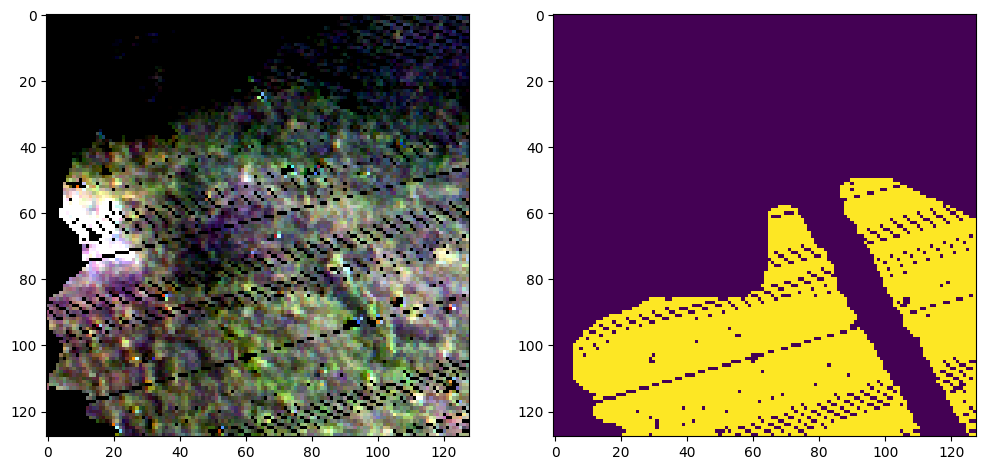

In [11]:
# Show example tile with annotation
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(image_render.percentile_stretch(np.array(hyspec_tiles[0])[:,:,rgb_ind]))
ax[1].imshow(np.array(annotation_tiles[0]))
plt.show()

In [12]:
# Collect random spectra from data for building a PCA model
# (Note: Can proably be optimized, this is just a "quick and dirty" way)
hyspec_samples = []
for tile in hyspec_tiles:
    hyspec_samples.append(hyspec_stats.random_sample_image(np.array(tile)))
hyspec_samples = np.concatenate(hyspec_samples,axis=0)
print(f'{hyspec_samples.shape=}')

hyspec_samples.shape=(58384, 173)


In [13]:
#%% Scaling and PCA model
scaler = sklearn.preprocessing.StandardScaler()
X_sc = scaler.fit_transform(hyspec_samples)

pca = sklearn.decomposition.PCA(n_components=10)   
X_pca = pca.fit_transform(X_sc)

In [14]:
# Show explained variance in PCA model
print(f'Explained variance per component (%): {pca.explained_variance_ratio_*100}')
print(f'Total explained variance: {sum(pca.explained_variance_ratio_)*100:.2f} %')

Explained variance per component (%): [71.98049    11.811149    3.6501472   2.106277    1.4344127   0.82018703
  0.4192526   0.34105954  0.3345712   0.32666695]
Total explained variance: 93.22 %


In [15]:
# PCA transformation of image tiles
pca_tiles = pca.transform(np.reshape(np.array(hyspec_tiles),[-1,hyspec_tiles.shape[-1]]))
pca_tiles = pca_tiles.reshape([*hyspec_tiles.shape[0:3],-1])
print(pca_tiles.shape)

(90, 128, 128, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


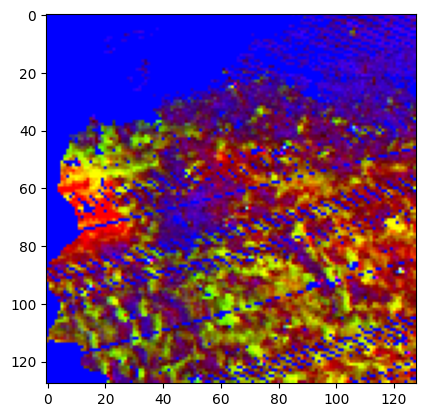

In [16]:
# Show example PCA tile (3 first components as RGB)
plt.imshow(image_render.percentile_stretch(pca_tiles[0,:,:,0:3]))
plt.show()

# Convolutional neural net for segmentation (U-Net)
Basing the model on the "pix2pix" down- and upsampling model in the TensorFlow examples https://www.tensorflow.org/tutorials/generative/pix2pix,
and on the TensorFlow image segmentation tutorial: https://www.tensorflow.org/tutorials/images/segmentation

In [17]:
# Downsample layer from pix2pix
def downsample(filter_channels, kernel_size, apply_batchnorm=True, name=None):
    """ Downsample layer from pix2pix
    
    # Input parameters:
    filter_channels:    Number of filters / "depth" of output
                        For images, this corresponds to number of color / wavelength channels
    kernel_size:        Spatial size of convolutional kernel
                        For images, if kernel_size = 3, each filter processes a 3x3 pixel neighborhood
    apply_batchnorm:    Boolean, whether to apply batch normalizetion (regularization)
                        before activation function.
    
    # Notes
    - Based on TF example pix2pix: https://www.tensorflow.org/tutorials/generative/pix2pix
    - Uses leaky ReLU activation
    - Slightly re-formatted by MHS
    """
    initializer = tf.random_normal_initializer(mean =0., stddev=0.02)              # Initializer for conv. layer                  

    result = tf.keras.Sequential(name=name)                                        # Initialize as sequential (stack of layers),
    result.add(                                                                    # Add single conv. layer
        tf.keras.layers.Conv2D(filter_channels, kernel_size, 
                               strides=2, padding='same',                          # Strides and padding correspond to factor-2 downsample
                               kernel_initializer=initializer, use_bias=False))    # ??? Should we never use bias? Even when not using batch norm.?

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())                             # Optional: Add batch normalization layer

    result.add(tf.keras.layers.LeakyReLU())                                        # Activation function

    return result

In [18]:
# Upsample layer from pix2pix
def upsample(filter_channels, kernel_size, apply_dropout=False, name=None):
    """ Upsample layer from pix2pix
    
    # Input parameters:
    filter_channels:    Number of filters / "depth" of output
                        For images, this corresponds to number of color / wavelength channels
    kernel_size:        Spatial size of convolutional kernel
                        For images, if kernel_size = 3, each filter processes a 3x3 pixel neighborhood
    apply_dropout:      Boolean, whether to apply dropout (regularization)
                        before activation function.
                        
    # Notes
    - Based on TF example pix2pix: https://www.tensorflow.org/tutorials/generative/pix2pix
    - Always uses batch normalization
    - Uses "regular" ReLU activation
    - Slightly re-formatted by MHS
    """
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential(name=name)                                         # Initialize as stack of layers
    result.add(
        tf.keras.layers.Conv2DTranspose(filter_channels, kernel_size, 
                                        strides=2, padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [19]:
def UNet(input_channels, output_channels, name=None):
    """ Simple encoder-decoder U-Net architecture
    
    # Arguments:
    input_channels:     Number of channels in input image
    output_channels:    Number of classes (including background) to segment between
    
    # Keyword arguments:
    name:               Name of model
    
    # Outputs:
    model:              Keras U-Net model
    
    # Notes:
    - Based on TF tutorial: https://www.tensorflow.org/tutorials/images/segmentation
    - Modified to decrease number of layers
    - The number of layers could easily be introduced as an adjustable hyperparameter, 
      due to the repeating and symmetric structure of downsampling / upsampling layers 
    """
    kernel_size = 4
    
    # Define downsampling layers
    down_stack = [
        downsample(64, kernel_size, apply_batchnorm=False, name='downsample_factor2'),  # (batch_size, Ny/2, Nx/2, 64)
        downsample(128, kernel_size, name='downsample_factor4'),  # (batch_size, Ny/4, Nx/4, 128)
        downsample(256, kernel_size, name='downsample_factor8'),  # (batch_size, Ny/8, Nx/8, 256)
        downsample(512, kernel_size, name='downsample_factor16'),  # (batch_size, Ny/16, Nx/16, 512)
    ]

    # Define upsampling layers, except last (see below)
    up_stack = [
        upsample(256, kernel_size, name='upsample_factor8'),  # (batch_size, Ny/8, Nx/8, 256)
        upsample(128, kernel_size, name='upsample_factor4'),  # (batch_size, Ny/4, Nx/4, 128)
        upsample(64, kernel_size, name='upsample_factor2'),   # (batch_size, Ny/2, Nx/2, 64)
    ]
    
    # Define input
    inputs = tf.keras.layers.Input(shape=[None, None, input_channels],name='input_image')   # Using None to signal variable image width and height (Ny,Nx,3)
    x = inputs    # x used as temparary variable for data flowing between layers

    # Downsampling through the model
    skips = []                    # List for saving references to downsampling layer outputs
    for down in down_stack:
        x = down(x)               # Run input x through layer, then set x equal to output
        skips.append(x)           # Add layer output to skips list

    skips = reversed(skips[:-1])  # Reverse list, and don't include skip for last layer ("bottom of U") 

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)                                     # Run input x through layer, then set x to output
        x = tf.keras.layers.Concatenate()([x, skip])  # Stack layer output together with skip connection (downsampling layer output with same resolution)
    
    # Define last layer, which upsamples to original resolution
    last = tf.keras.layers.Conv2DTranspose(output_channels, kernel_size,
                                     strides=2,
                                     padding='same',
                                     kernel_initializer = tf.random_normal_initializer(0., 0.02),
                                     activation='softmax',
                                     name='final_upsample_and_classify')  # (batch_size, Ny, Nx, 3)    
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x,name=name)

In [20]:
# Create the U-Net model
unet = UNet(input_channels = pca_tiles.shape[-1],
            output_channels = len(np.unique(annotation_tiles)),
            name='massimal_unet')
unet.summary()

Model: "massimal_unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 10)]                                                             
                                                                                                  
 downsample_factor2 (Sequential  (None, None, None,   10240      ['input_image[0][0]']            
 )                              64)                                                               
                                                                                                  
 downsample_factor4 (Sequential  (None, None, None,   131584     ['downsample_factor2[0][0]']     
 )                              128)                                                  

In [21]:
tf.keras.utils.plot_model(unet, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
# Create tensorflow dataset
sample_weights = np.array(annotation_tiles!=0,dtype=np.float32)
#sample_weights[sample_weights==0] = 0.001  # Small weight given to background - not very promising
sample_weights[sample_weights==0] = 0.0  # Weight of background pixels
#sample_weights = tf.cast(annotation_tiles!=0, tf.int32) # Weight annotated pixels to 1, all other to 0
dataset = tf.data.Dataset.from_tensor_slices((pca_tiles,annotation_tiles,sample_weights))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


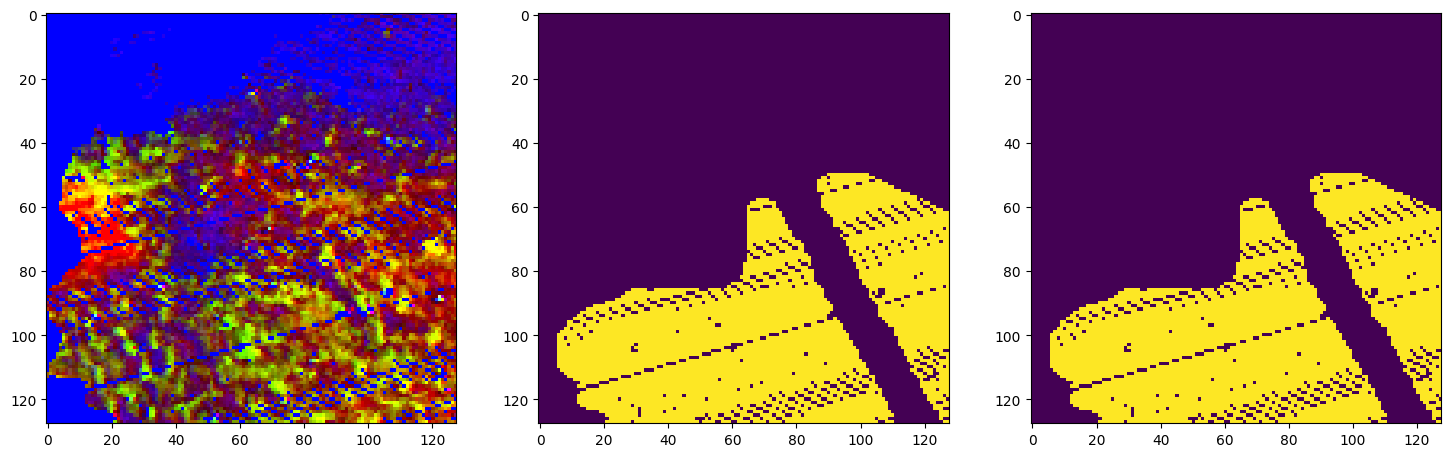

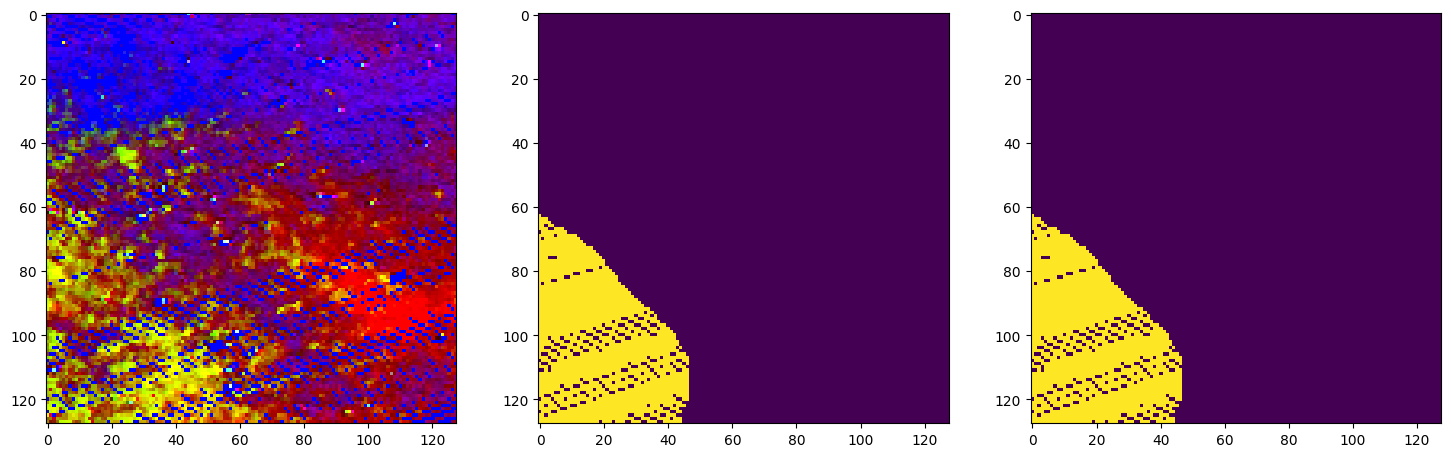

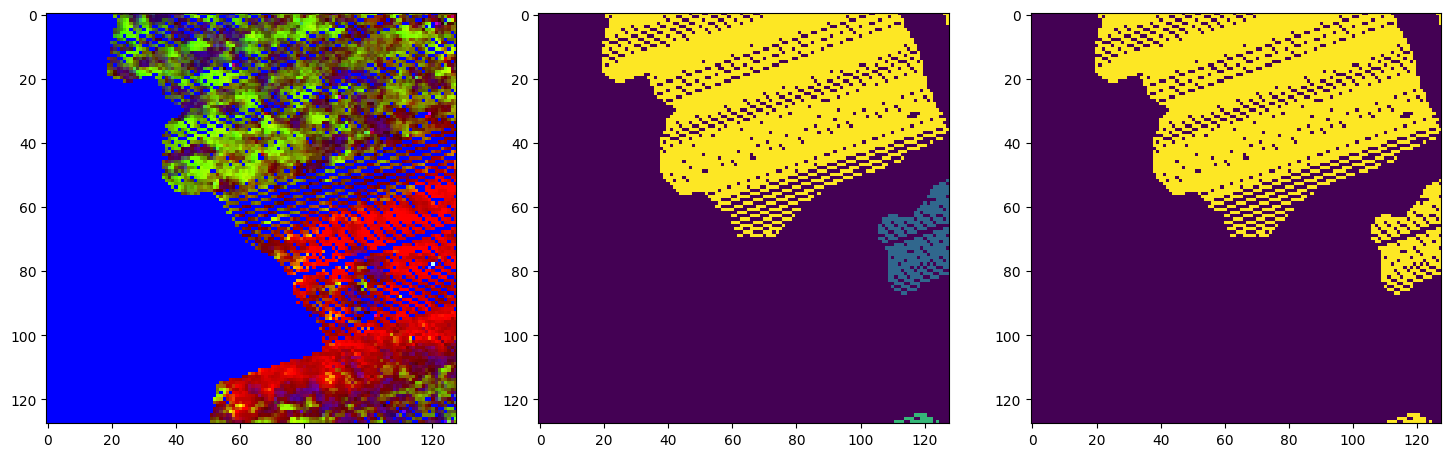

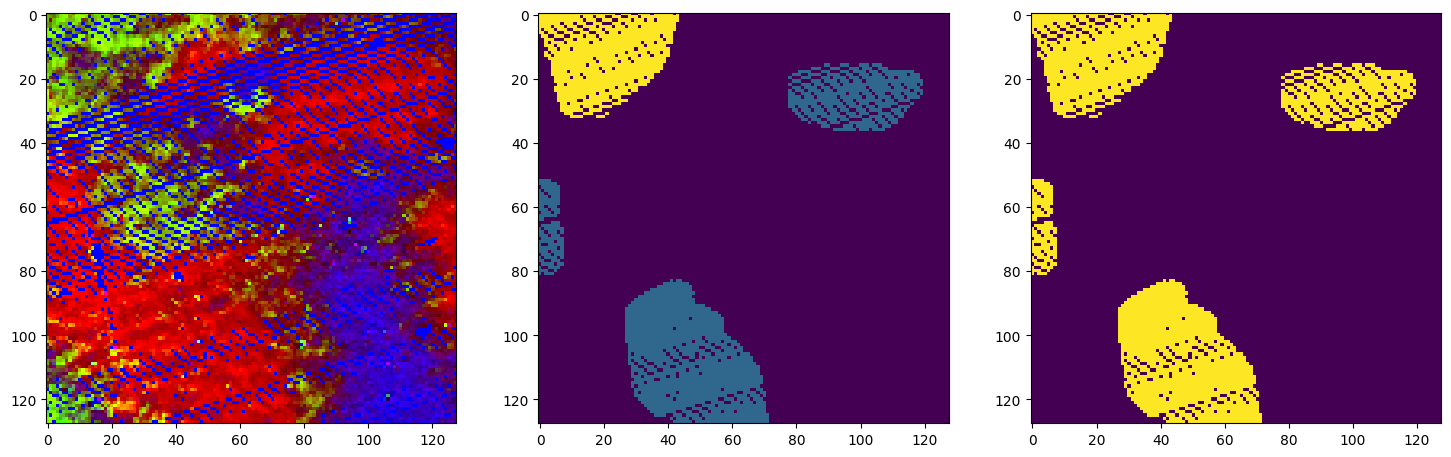

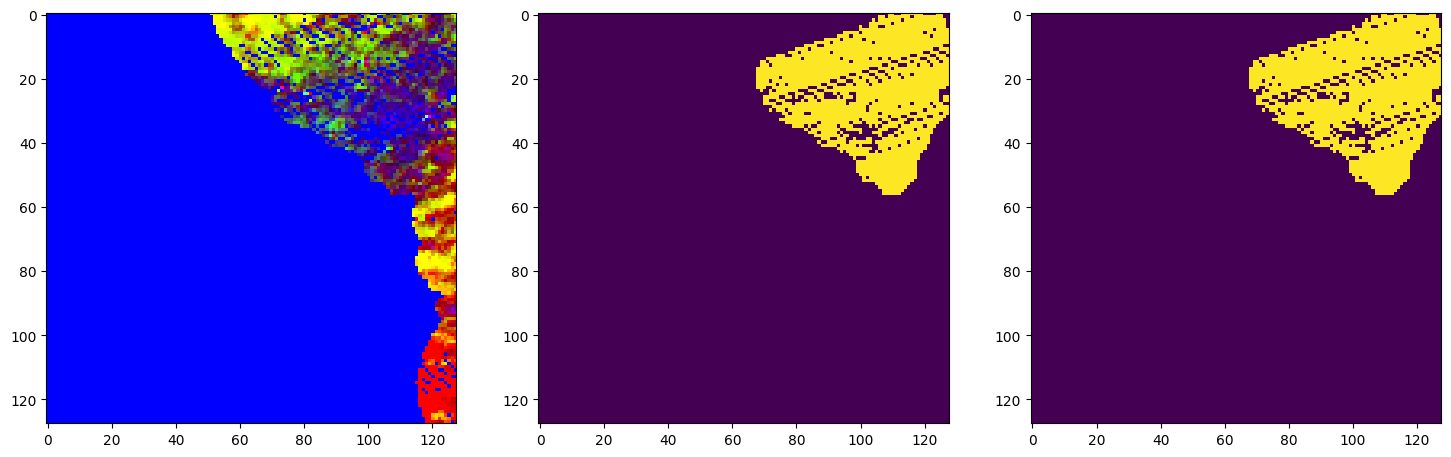

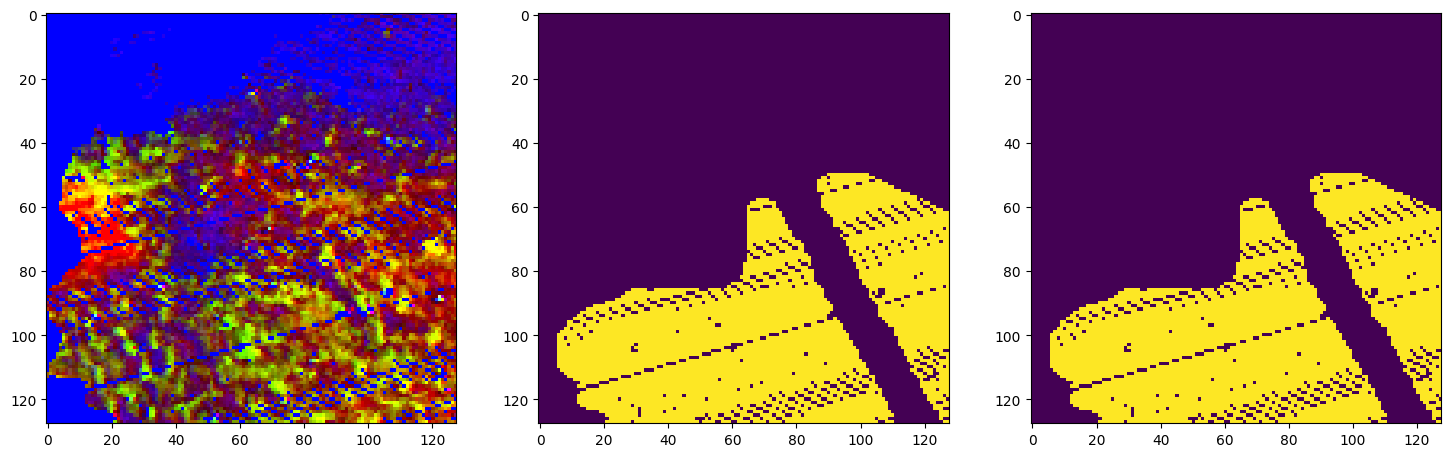

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


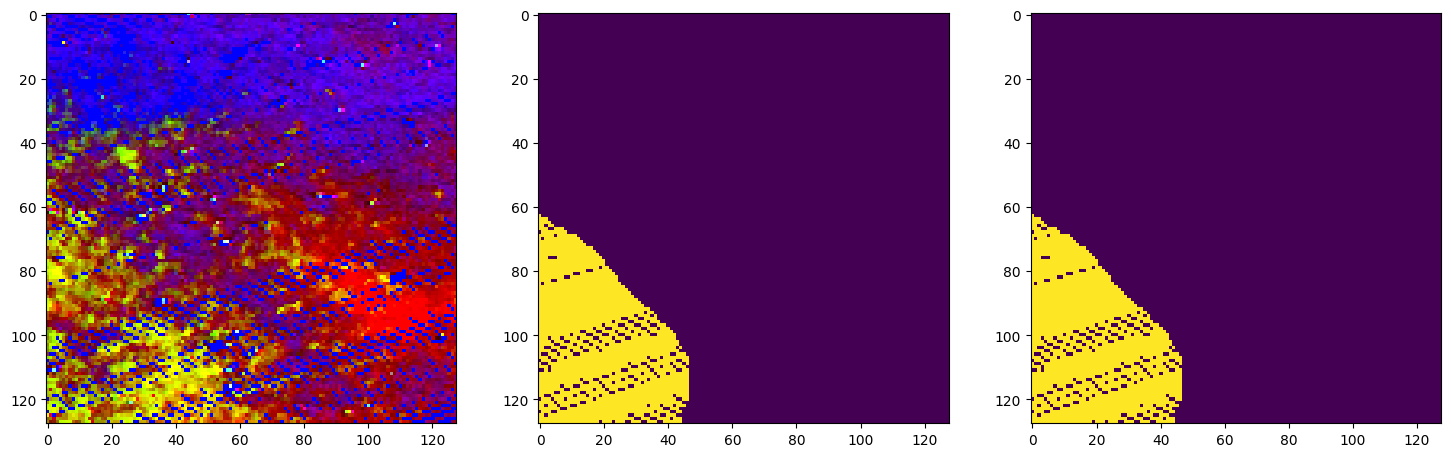

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


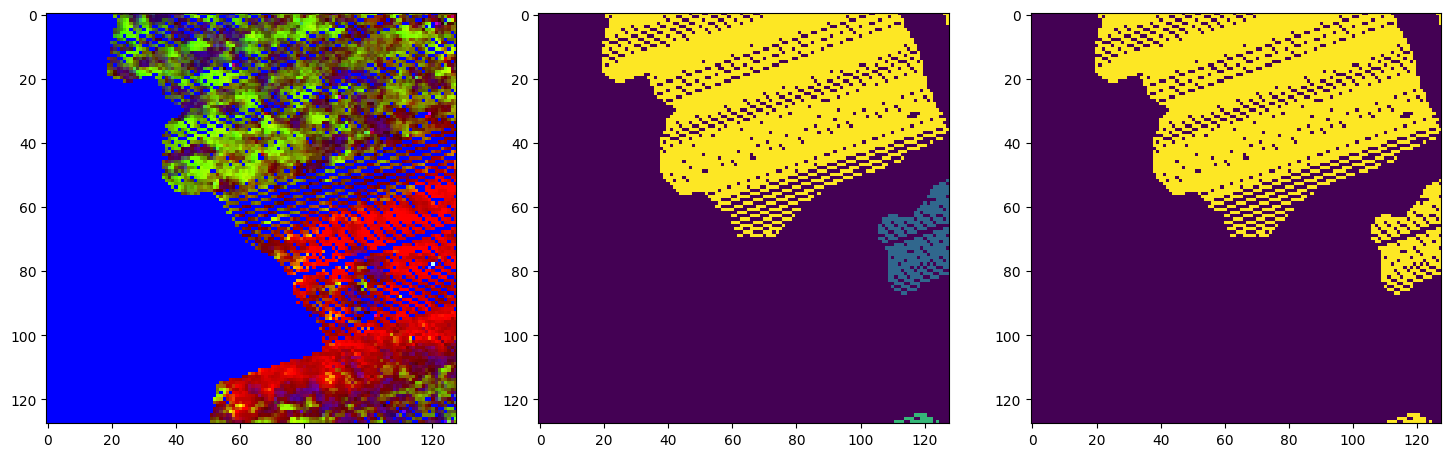

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


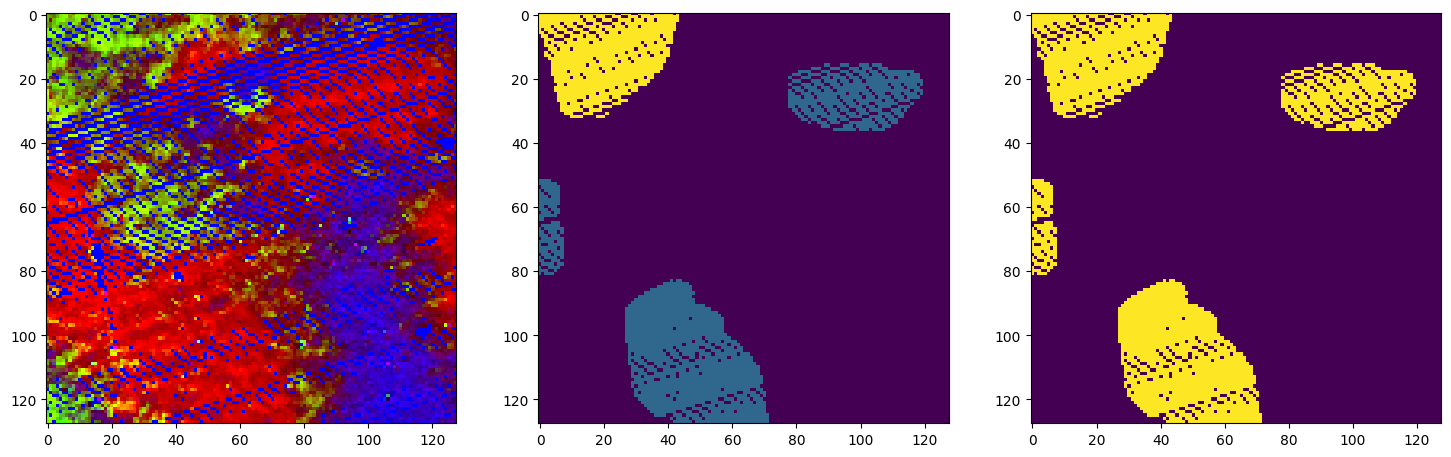

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


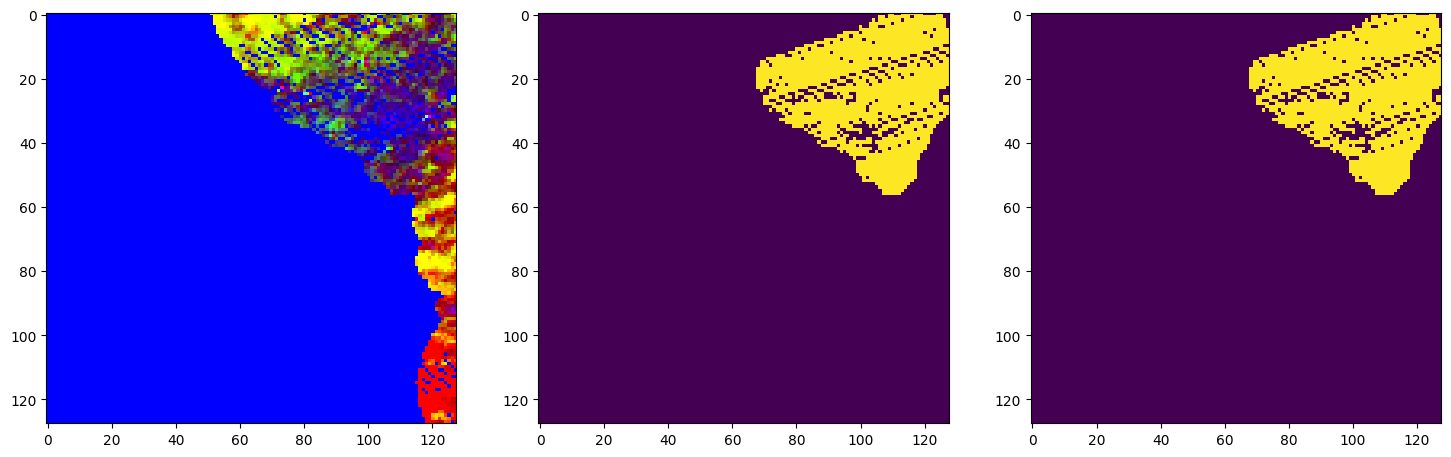

In [24]:
# Show some of the elements of the dataset
for image, mask, weights in dataset.take(5):    # Note: Must interate over dataset to "get" elements
    fig,ax = plt.subplots(1,3,figsize=(18,6))
    ax[0].imshow(image_render.percentile_stretch(np.array(image)[:,:,0:3]))
    ax[1].imshow(np.array(mask))
    ax[2].imshow(np.array(weights))
    plt.show()

In [25]:
# Split into training and validation datasets, create batches
n_val_tiles = int(TEST_FRAC*len(dataset))

dataset = dataset.shuffle(len(dataset))
val_dataset = dataset.take(n_val_tiles).batch(BATCH_SIZE)
train_dataset = dataset.skip(n_val_tiles).batch(BATCH_SIZE)

In [26]:
# Compile model. NOTE: Need smaller learning rate than standard RMSprop
#unet.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",weighted_metrics=[])
unet.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001), loss="sparse_categorical_crossentropy",weighted_metrics=[])
#unet.compile(optimizer=tf.keras.optimizers.RMSprop(0.00005), loss="sparse_categorical_crossentropy",weighted_metrics=[])


In [27]:
# Fit model to dataset
history = unet.fit(train_dataset,
                   epochs=80,
                   validation_data=val_dataset)


Epoch 1/80
8/8 [==============================] - 5s 416ms/step - loss: 8.5700 - val_loss: 6.1535
Epoch 2/80
8/8 [==============================] - 3s 370ms/step - loss: 4.1744 - val_loss: 4.0237
Epoch 3/80
8/8 [==============================] - 3s 379ms/step - loss: 4.0847 - val_loss: 2.9295
Epoch 4/80
8/8 [==============================] - 3s 388ms/step - loss: 3.5193 - val_loss: 5.2015
Epoch 5/80
8/8 [==============================] - 3s 387ms/step - loss: 3.6199 - val_loss: 3.4634
Epoch 6/80
8/8 [==============================] - 3s 373ms/step - loss: 2.7695 - val_loss: 4.2578
Epoch 7/80
8/8 [==============================] - 3s 374ms/step - loss: 2.4346 - val_loss: 2.5268
Epoch 8/80
8/8 [==============================] - 3s 376ms/step - loss: 1.9236 - val_loss: 2.6107
Epoch 9/80
8/8 [==============================] - 3s 370ms/step - loss: 2.2570 - val_loss: 1.9434
Epoch 10/80
8/8 [==============================] - 3s 366ms/step - loss: 1.9621 - val_loss: 1.9007
Epoch 11/80
8/8 [==

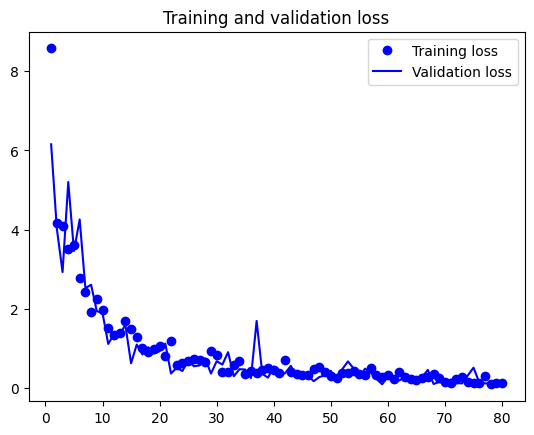

In [28]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [29]:
def pad_image_to_multiple(image,multiple):
    """ Pad image spatially dimension to multiple of given number """
    nrows_pad = math.ceil(image.shape[0]/multiple)*multiple
    ncols_pad = math.ceil(image.shape[1]/multiple)*multiple
    image_padded = np.zeros_like(image,shape=[nrows_pad, ncols_pad, image.shape[-1]])
    image_padded[0:image.shape[0], 0:image.shape[1],:] = image
    return image_padded

In [30]:
pca_image = pca.transform(np.reshape(hyspec_image,(-1,hyspec_image.shape[-1])))
pca_image = np.reshape(pca_image,[*hyspec_image.shape[0:2],-1])
pca_image = pad_image_to_multiple(pca_image,16)

1/1 [==============================] - 0s 27ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


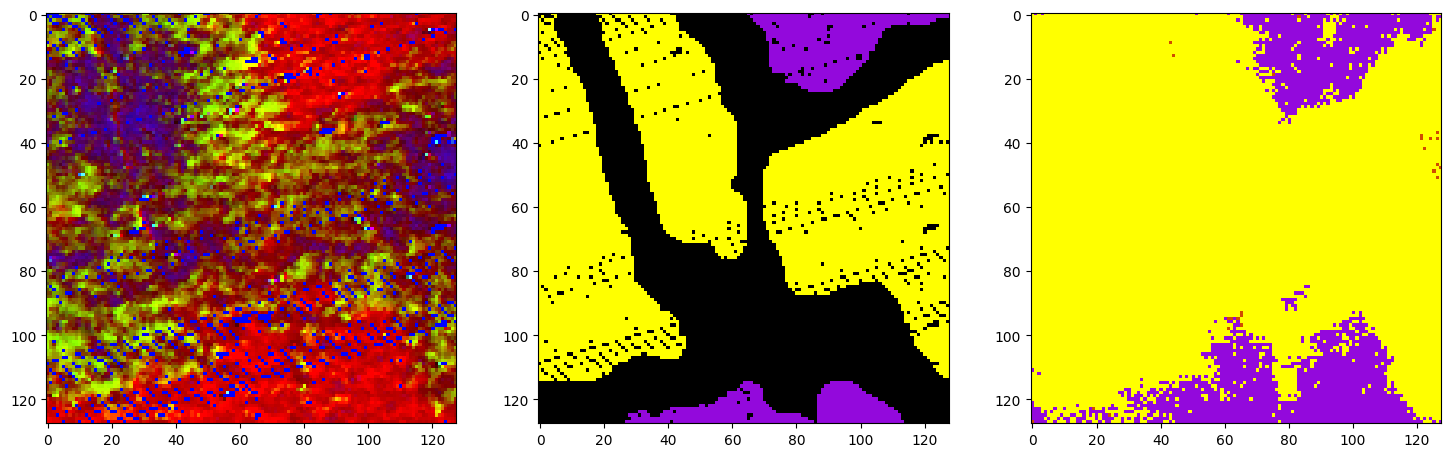

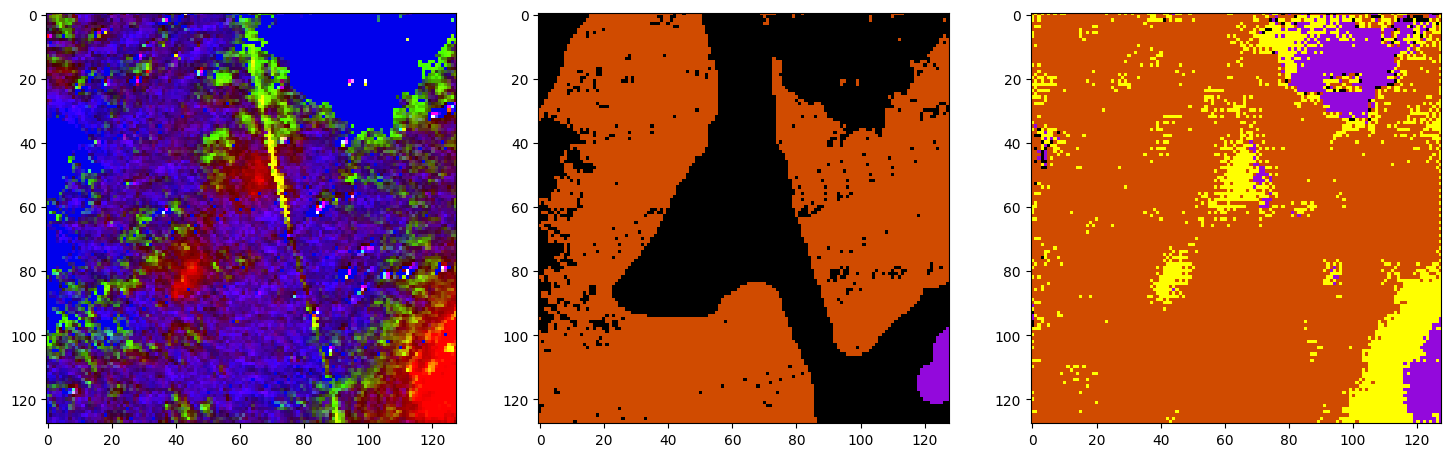

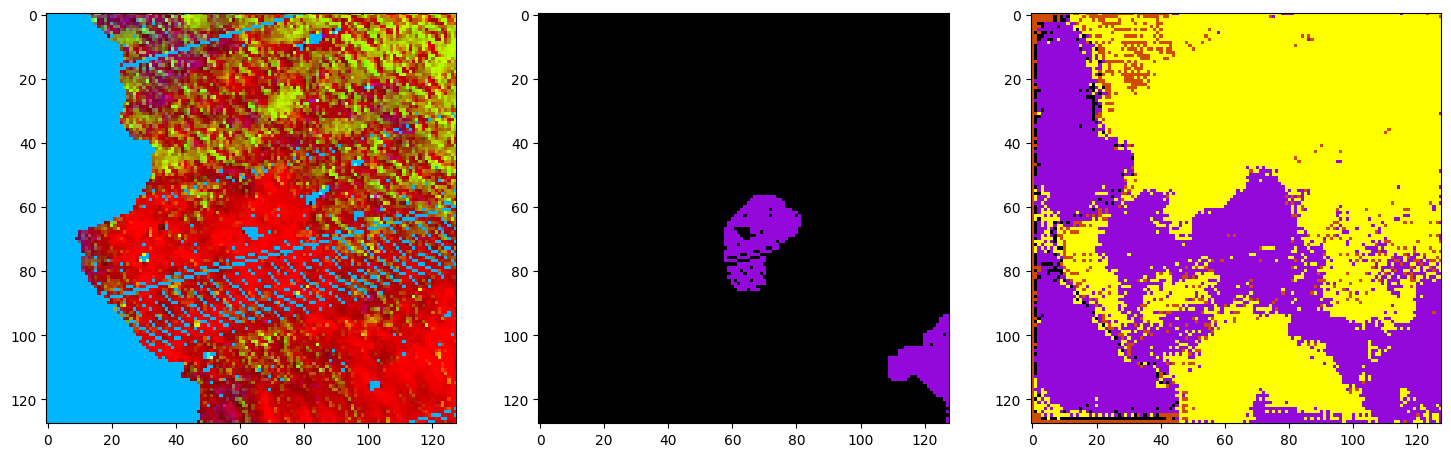

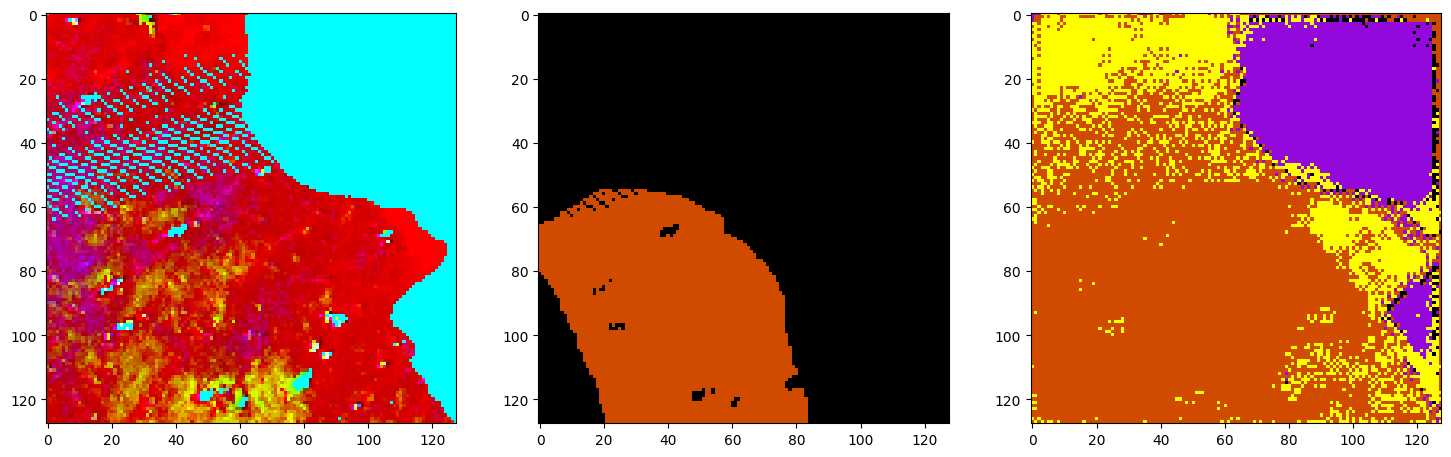

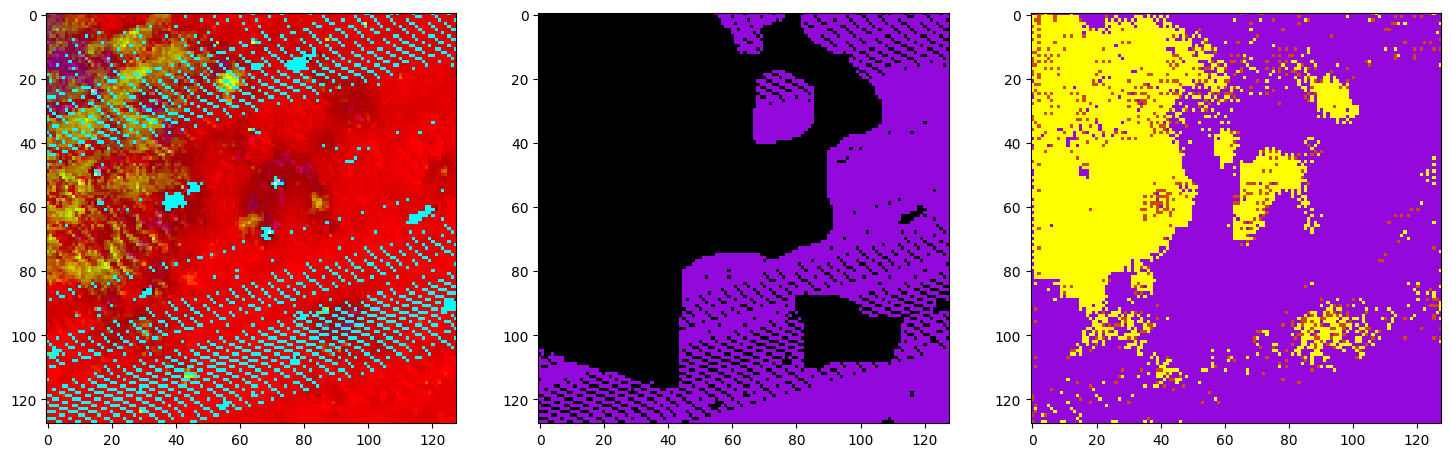

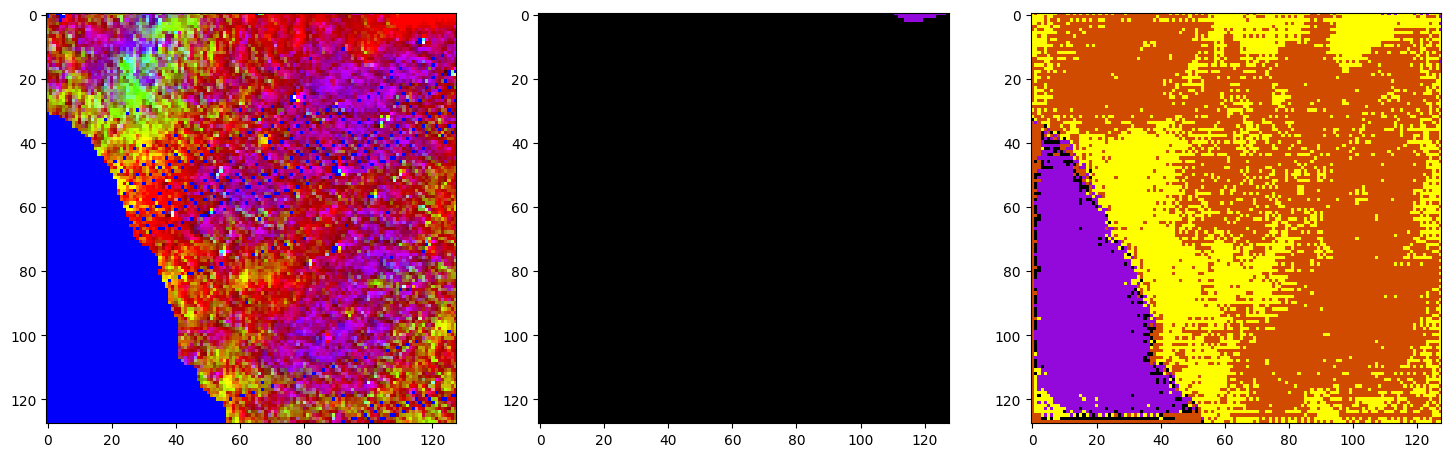

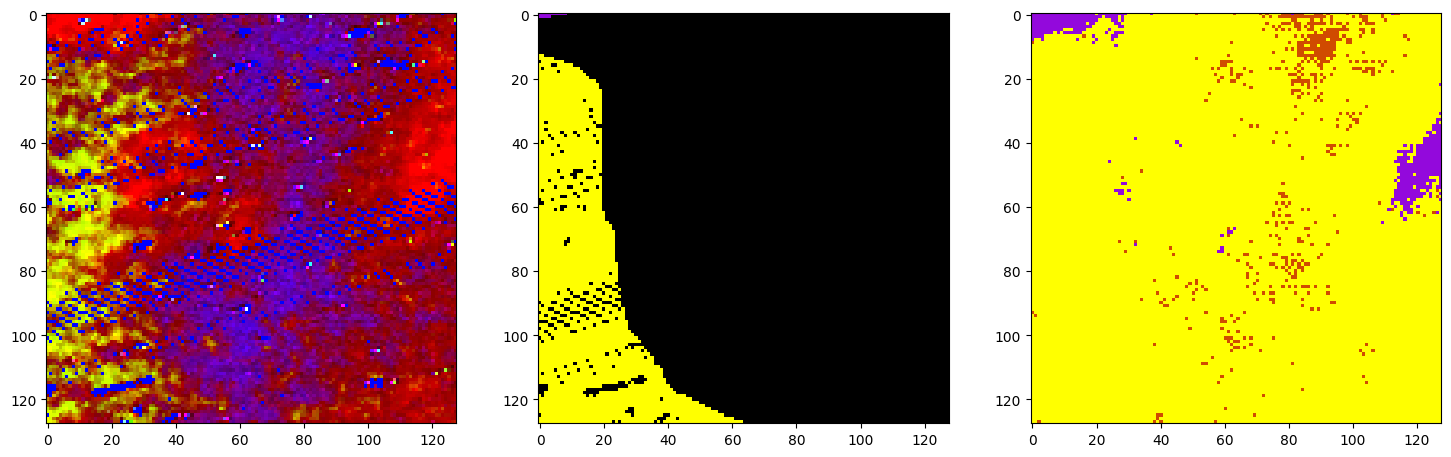

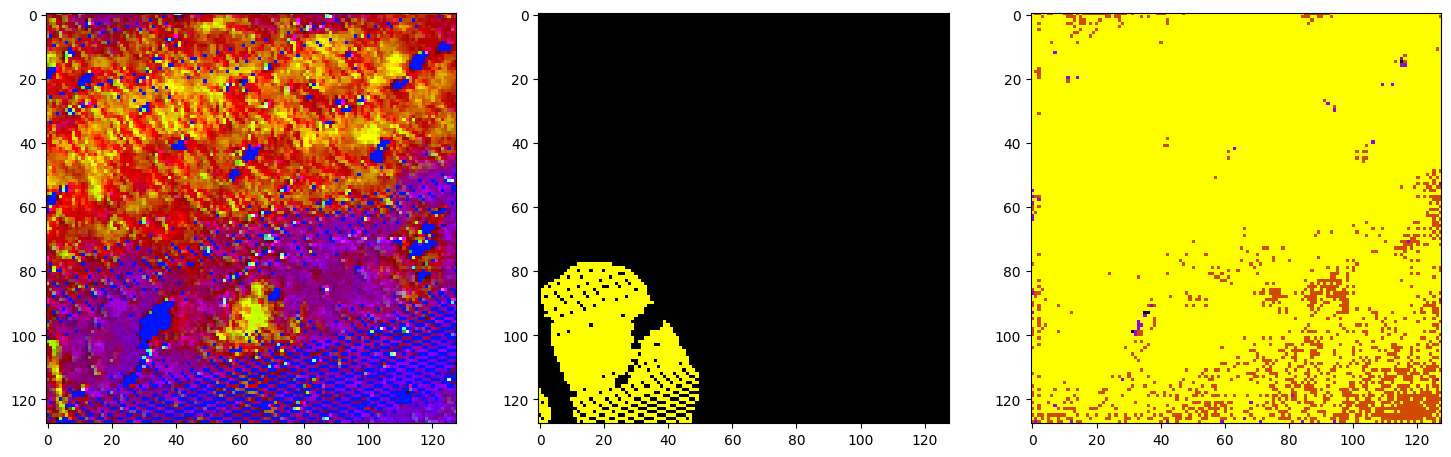

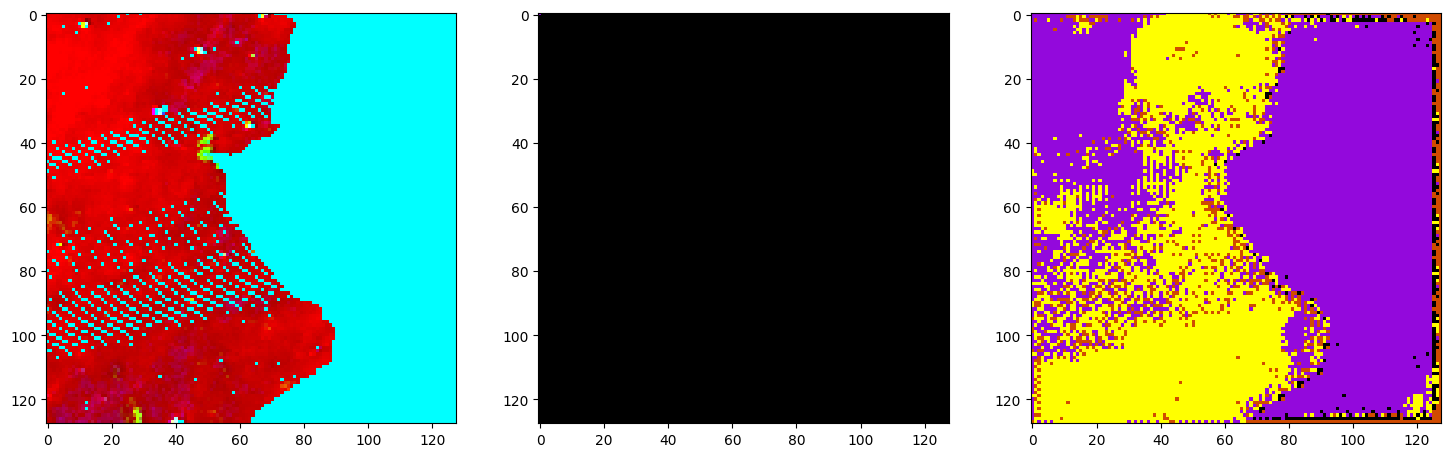

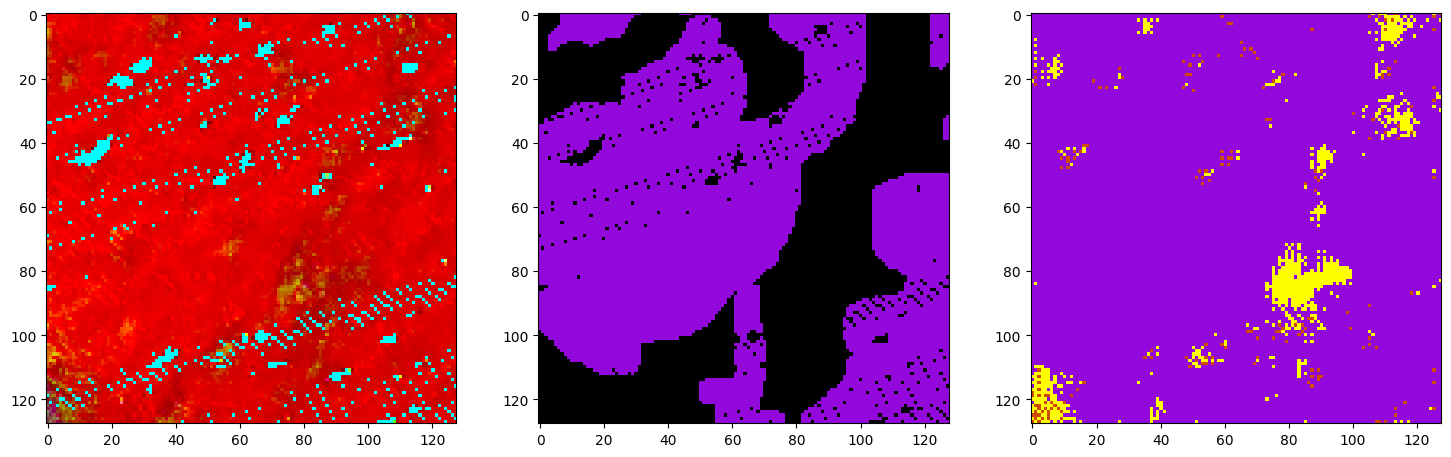

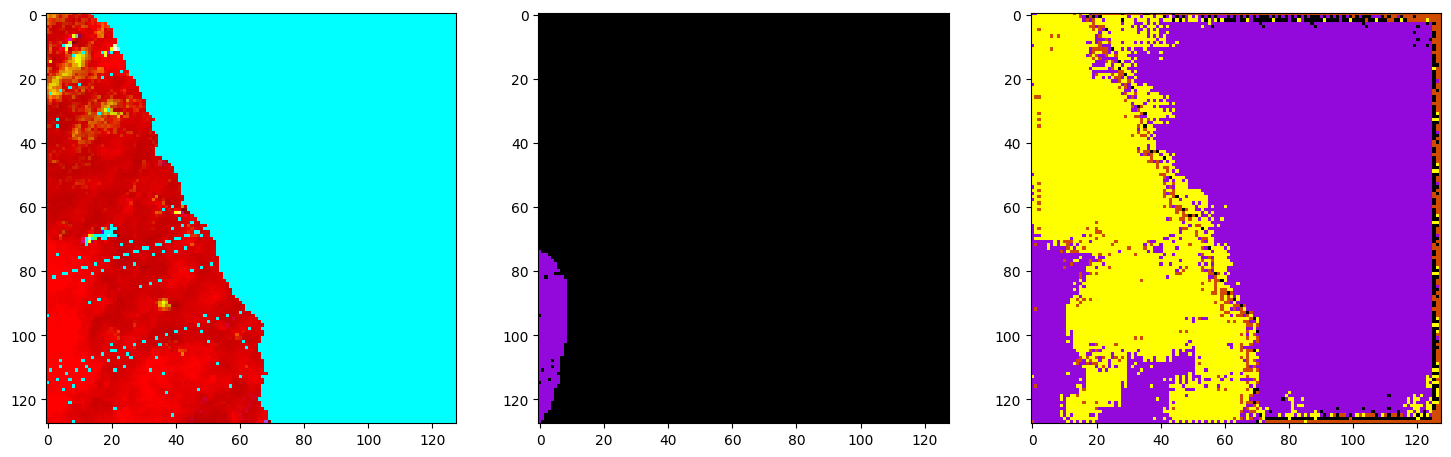

1/1 [==============================] - 0s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


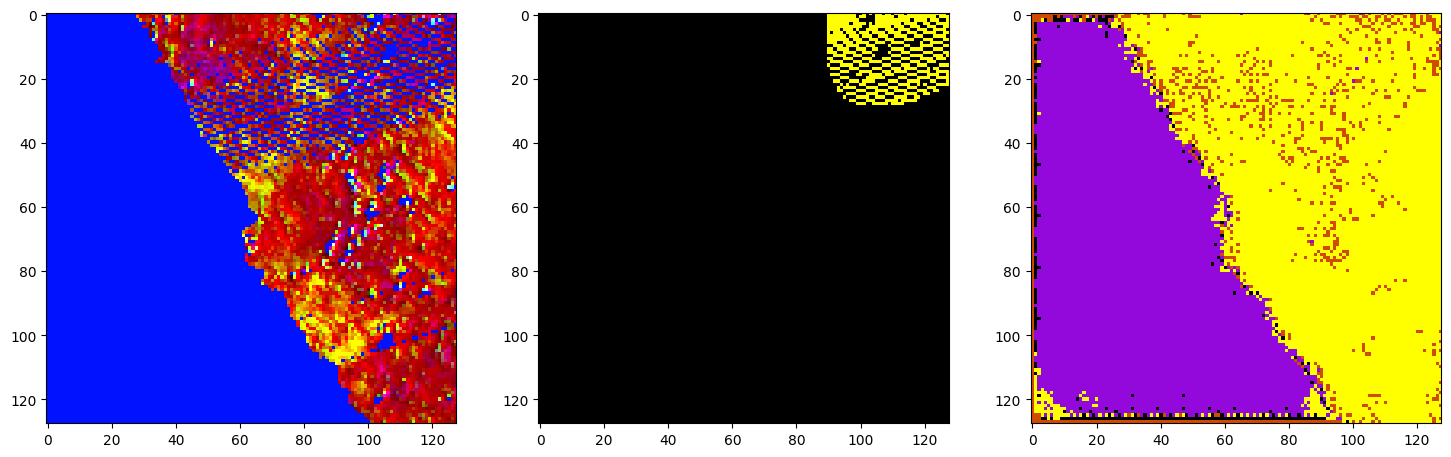

1/1 [==============================] - 0s 88ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


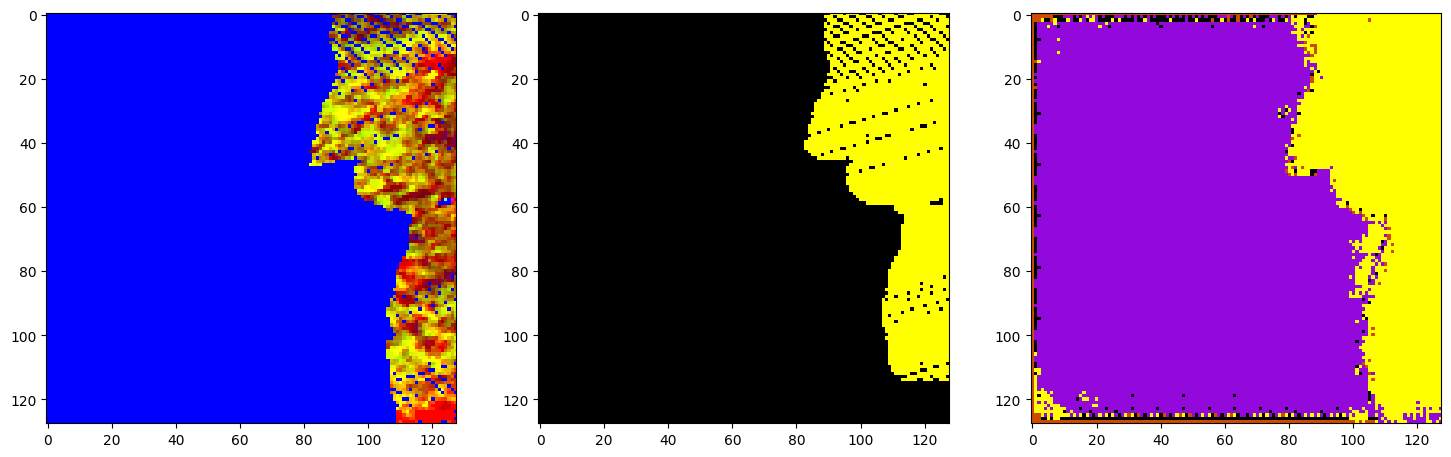

1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


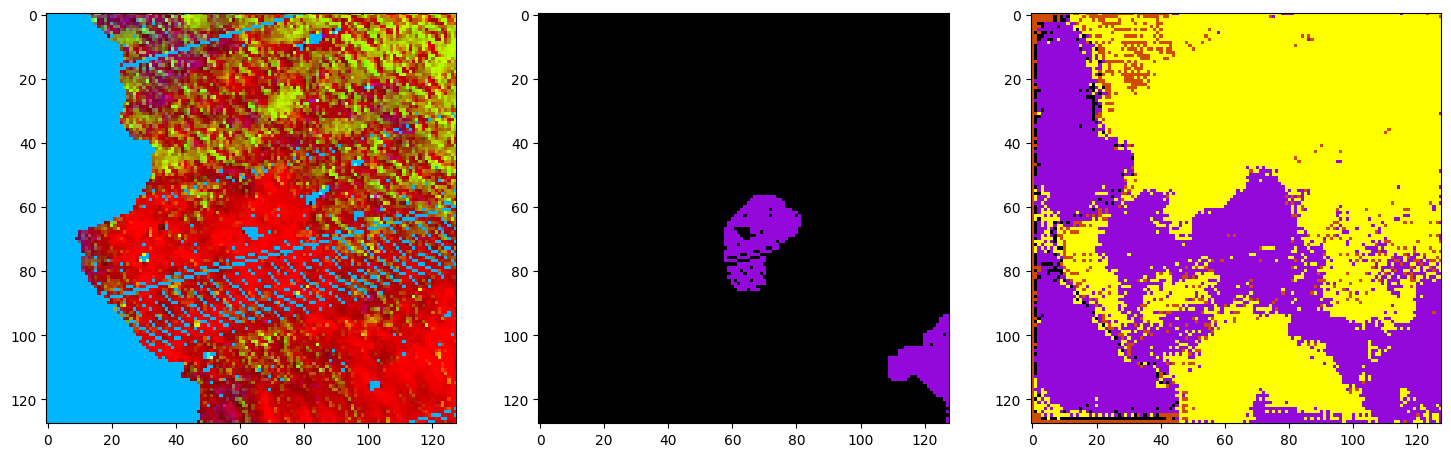

1/1 [==============================] - 0s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


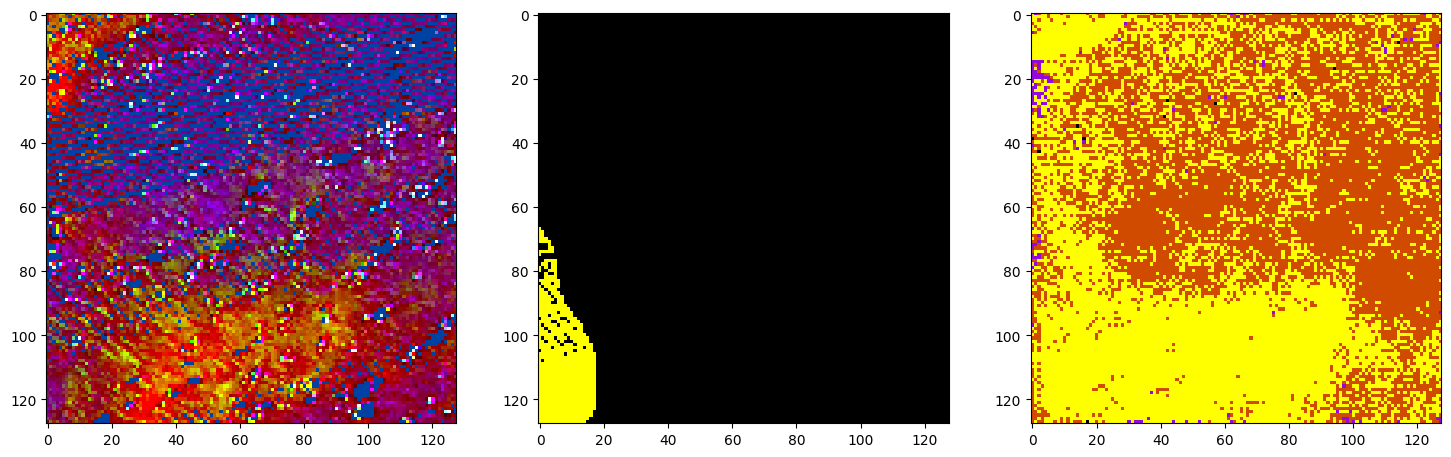

1/1 [==============================] - 0s 27ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


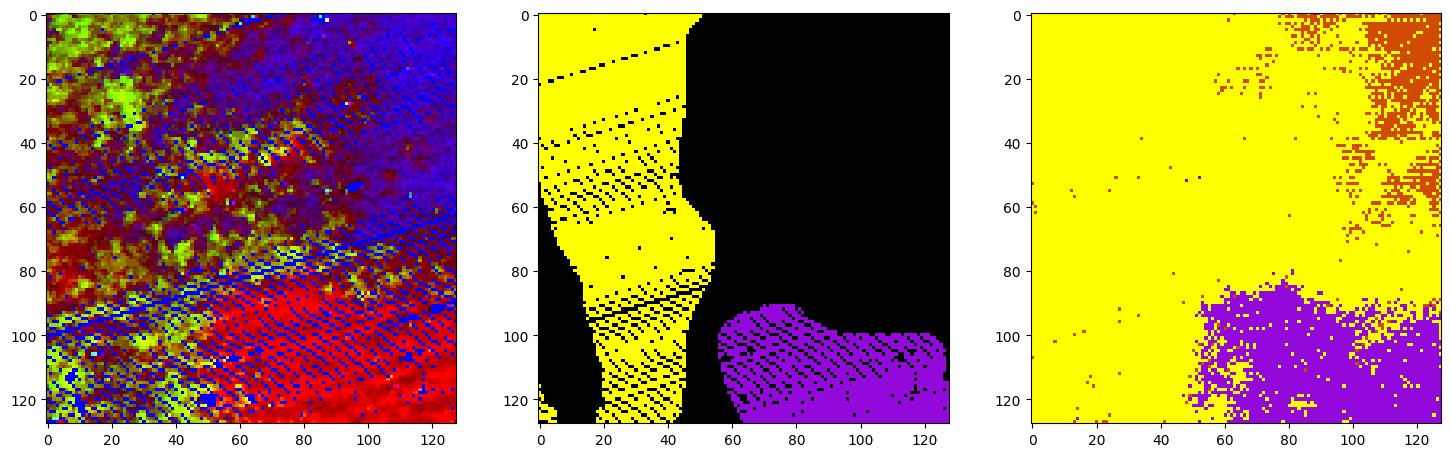

1/1 [==============================] - 0s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


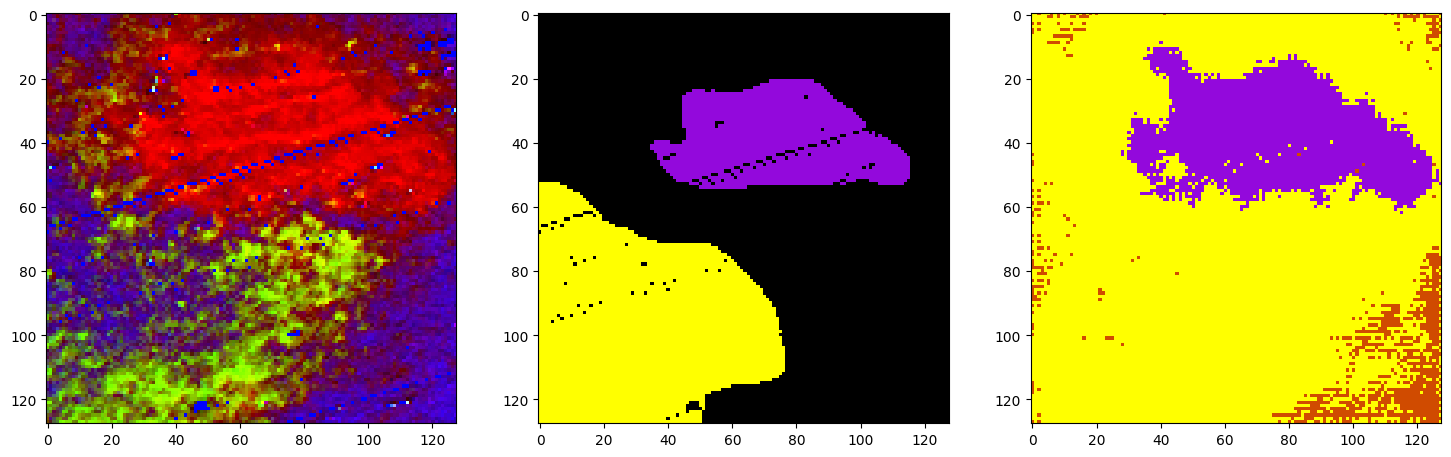

1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


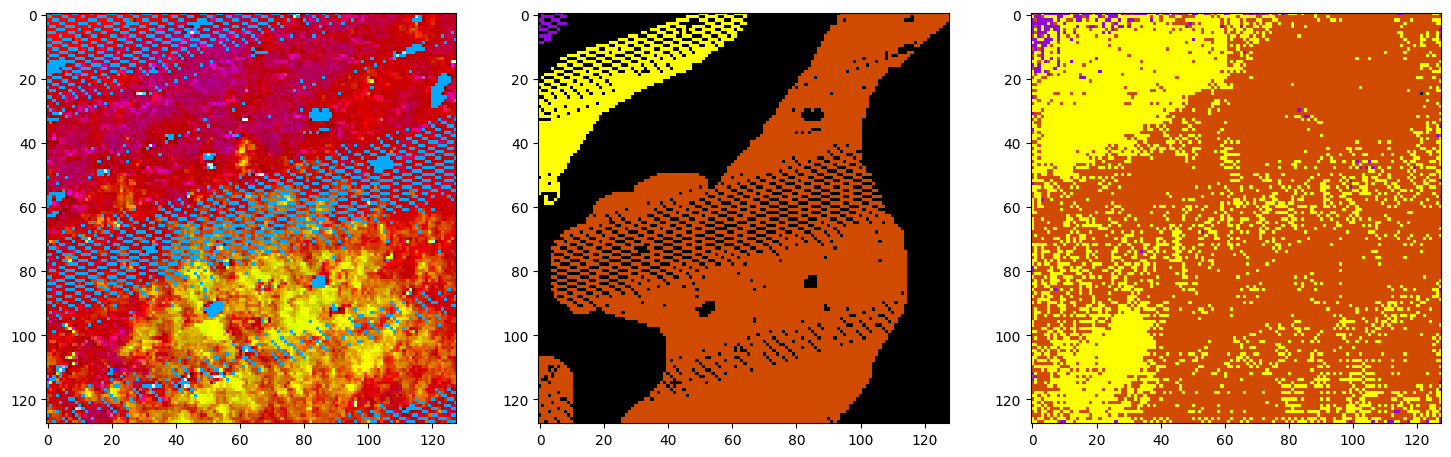

1/1 [==============================] - 0s 29ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


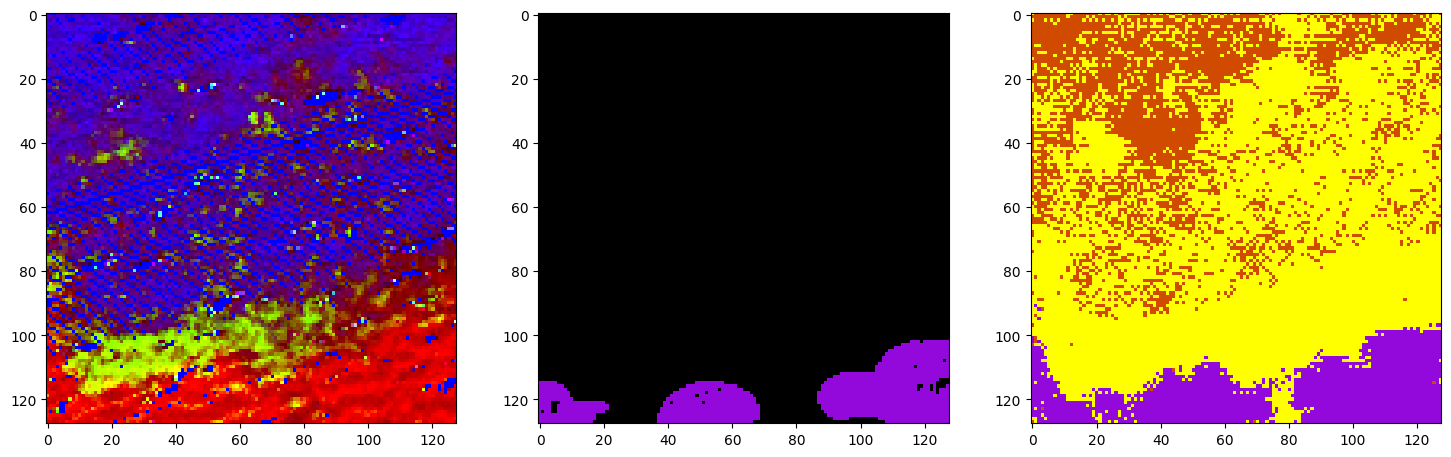

1/1 [==============================] - 0s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


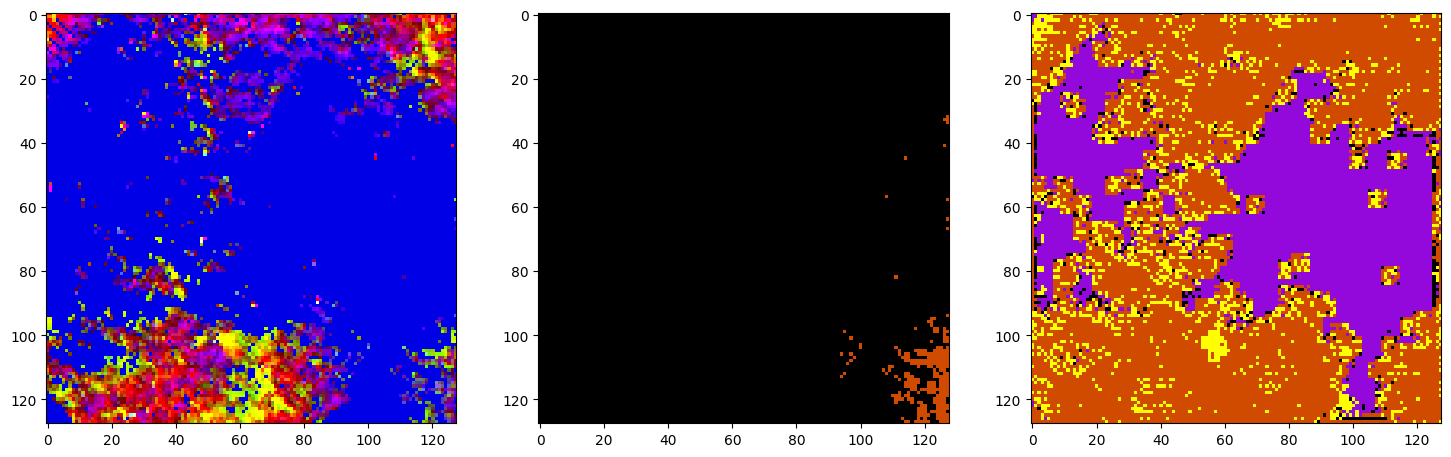

In [32]:
# Show some of the elements of the dataset
for image, mask, weights in dataset.take(10):    # Note: Must interate over dataset to "get" elements
    tile_segm = np.argmax(np.squeeze(unet.predict(np.expand_dims(image,axis=0))), axis=2)
    
    fig,ax = plt.subplots(1,3,figsize=(18,6))
    ax[0].imshow(image_render.percentile_stretch(np.array(image)[:,:,0:3]))
    ax[1].imshow(np.array(mask),vmin = 0, vmax=3,cmap='gnuplot',interpolation='none')
    ax[2].imshow(np.array(tile_segm),vmin = 0, vmax=3,cmap='gnuplot',interpolation='none')
    plt.show()

In [33]:
segm_image = unet.predict(np.expand_dims(pca_image,axis=0))
segm_image = np.argmax(segm_image.squeeze(),axis=2)

1/1 [==============================] - 1s 964ms/step


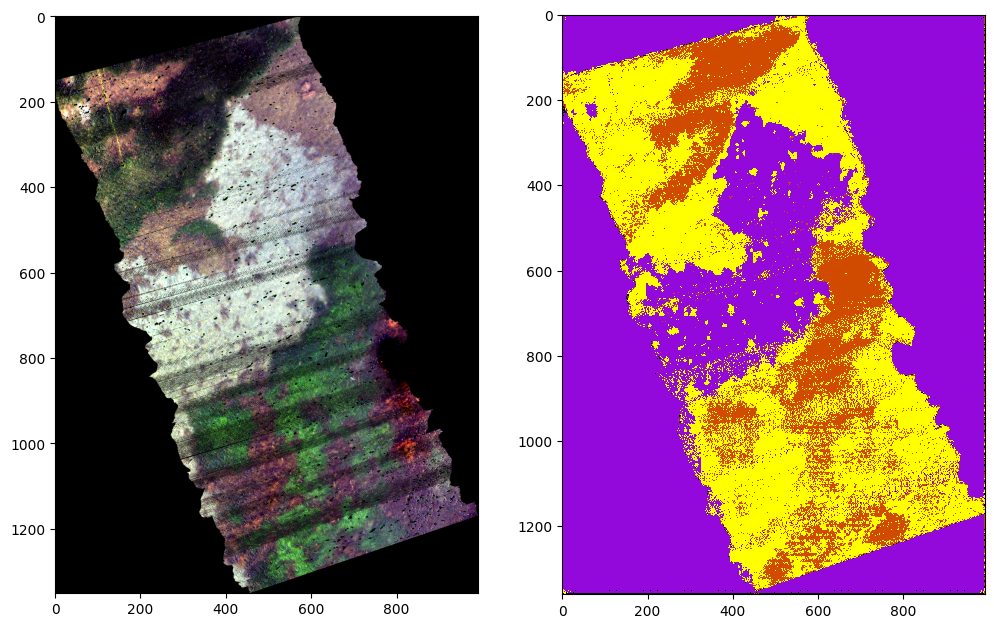

In [37]:
fig,ax = plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(image_render.percentile_stretch(hyspec_image[:,:,rgb_ind]))
ax[1].imshow(segm_image,vmin=0,vmax=3,cmap='gnuplot',interpolation='none')
plt.show()